In [ ]:
import skimage
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = 'content'
color_imgs = skimage.io.ImageCollection(data_dir + '/color/*.tif')
normal_imgs = skimage.io.ImageCollection(data_dir + '/normal/*.tif')

In [ ]:
color_imgs = skimage.img_as_float([color_imgs[x] for x in range(len(color_imgs))])
normal_imgs = skimage.img_as_float([normal_imgs[x] for x in range(len(normal_imgs))])

In [ ]:
seed = np.random.randint(999)
np.random.seed(seed); np.random.shuffle(color_imgs)
np.random.seed(seed); np.random.shuffle(normal_imgs)

In [ ]:
color_imgs[0].shape

(512, 512, 3)

In [ ]:
color_train_set, color_test_set, normal_train_set, normal_test_set = train_test_split(color_imgs, normal_imgs, test_size=0.30, random_state=42)

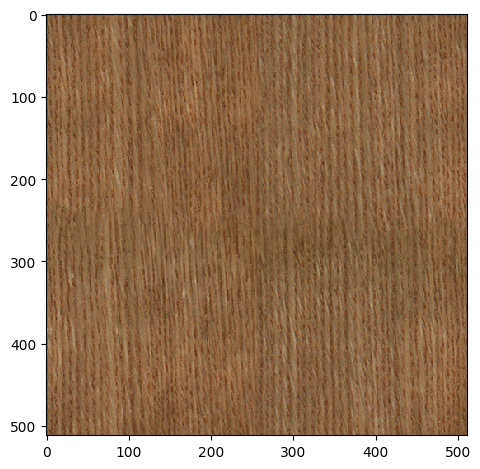

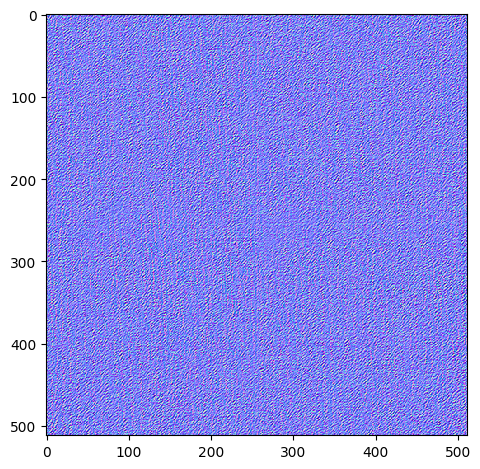

In [ ]:
skimage.io.imshow(skimage.img_as_ubyte(color_train_set[0]))
plt.show()
skimage.io.imshow(skimage.img_as_ubyte(normal_train_set[0]))
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 660839528668320217
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 885395721970529209
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
img_size = 512
input_img = Input(shape=(img_size, img_size, 3))

ng = Conv2D(15, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
ng = BatchNormalization()(ng)
ng = AveragePooling2D((4, 4), padding='same')(ng)
ng = Conv2D(30, (3, 3), activation='relu', padding='same', use_bias=False)(ng)
ng = BatchNormalization()(ng)
ng = UpSampling2D((4, 4))(ng)
ng = Conv2D(15, (3, 3), activation='relu', padding='same', use_bias=False)(ng)
ng = BatchNormalization()(ng)
ng = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(ng)
normal_generator = Model(input_img, ng)
normal_generator.compile(Adam(amsgrad=True), loss='mse')

In [ ]:
normal_generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 15)      405       
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 15)     60        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 15)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 30)      4050      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 30)     120   

In [ ]:
normal_generator.fit(color_train_set, normal_train_set,
                     validation_data = (color_test_set, normal_test_set),
                     batch_size=15,
                     epochs=250, workers=10,
                     use_multiprocessing=True)

Epoch 1/250
6/6 [==============================] - 17s 870ms/step - loss: 0.1227 - val_loss: 0.0823
Epoch 2/250
6/6 [==============================] - 2s 270ms/step - loss: 0.1005 - val_loss: 0.0804
Epoch 3/250
6/6 [==============================] - 2s 271ms/step - loss: 0.0915 - val_loss: 0.0785
Epoch 4/250
6/6 [==============================] - 2s 280ms/step - loss: 0.0860 - val_loss: 0.0781
Epoch 5/250
6/6 [==============================] - 2s 271ms/step - loss: 0.0826 - val_loss: 0.0760
Epoch 6/250
6/6 [==============================] - 2s 267ms/step - loss: 0.0786 - val_loss: 0.0724
Epoch 7/250
6/6 [==============================] - 2s 266ms/step - loss: 0.0758 - val_loss: 0.0709
Epoch 8/250
6/6 [==============================] - 2s 294ms/step - loss: 0.0714 - val_loss: 0.0657
Epoch 9/250
6/6 [==============================] - 2s 300ms/step - loss: 0.0684 - val_loss: 0.0626
Epoch 10/250
6/6 [==============================] - 2s 275ms/step - loss: 0.0649 - val_loss: 0.0586
Epoch 11

In [ ]:
def test_net_with_random_image():
    idx = int(np.random.rand(1)*len(color_test_set))
    y_legit = skimage.img_as_float(normal_test_set[idx]).reshape(1,img_size,img_size,3)
    y_fake = normal_generator.predict(skimage.img_as_float(color_test_set[idx]).reshape(1,img_size,img_size,3))
    skimage.io.imshow(skimage.img_as_ubyte(y_legit).reshape(img_size,img_size,3))
    plt.show()
    skimage.io.imshow(skimage.img_as_ubyte(y_fake).reshape(img_size,img_size,3))
    plt.show()

1/1 [==============================] - 0s 375ms/step


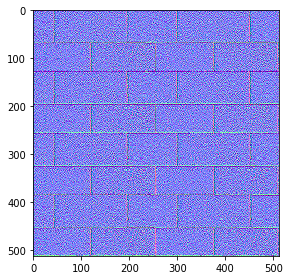

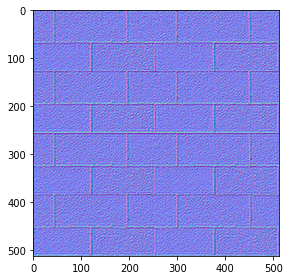

In [ ]:
test_net_with_random_image()

In [ ]:
normal_generator.save('model.h5')

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras '/content/model.h5' '/content/model'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━

In [ ]:
!python -m pip install -U imagecodecs[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.5 MB/s eta 0:00:00


In [ ]:
import imagecodecs
test_img = skimage.io.imread('brick_test.tiff')
skimage.io.imshow(skimage.img_as_ubyte(test_img))
test_img = skimage.img_as_float(test_img)
norm = normal_generator.predict(test_img)
skimage.io.imshow(skimage.img_as_ubyte(norm).reshape(img_size,img_size,3))

ValueError: ignored

In [ ]:
def test_net_with_random_image_i(idx):
    y_legit = skimage.img_as_float(normal_test_set[idx]).reshape(1,img_size,img_size,3)
    y_fake = normal_generator.predict(skimage.img_as_float(color_test_set[idx]).reshape(1,img_size,img_size,3))
    skimage.io.imshow(skimage.img_as_ubyte(y_legit).reshape(img_size,img_size,3))
    plt.show()
    skimage.io.imshow(skimage.img_as_ubyte(y_fake).reshape(img_size,img_size,3))
    plt.show()
    return y_fake

1/1 [==============================] - 0s 206ms/step


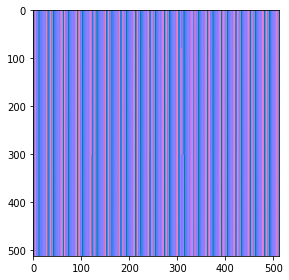

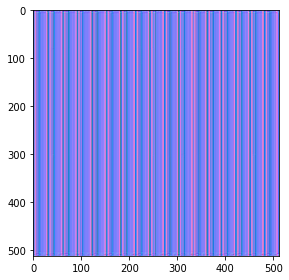

In [ ]:
temp = test_net_with_random_image_i(0)

In [ ]:
!pip install keras.layers.merge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.layers.merge (from versions: none)
ERROR: No matching distribution found for keras.layers.merge


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merging.concatenate import Concatenate
from keras.layers.merging.add import Add
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = Concatenate()([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = Concatenate()([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = Concatenate()([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = Concatenate()([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
img_size = 512
input_img = Input(shape=(img_size, img_size, 3))

#input_img = Input((img_size, img_size, 1), name='img')

model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 512, 512, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

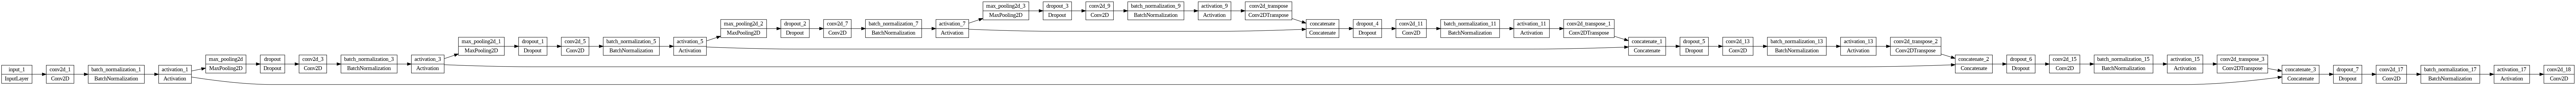

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
#                     color_train_set, normal_train_set,
#                     validation_data = (color_test_set, normal_test_set),
#                     batch_size=15,
#                     epochs=250, workers=10,
#                     use_multiprocessing=True)

results = model.fit(color_train_set, normal_train_set, batch_size=32, epochs=250, #callbacks=callbacks,\
                    validation_data = (color_test_set, normal_test_set), workers=10, use_multiprocessing=True)

Epoch 1/250
3/3 [==============================] - 7s 2s/step - loss: 0.6959 - accuracy: 0.2668 - val_loss: 0.6919 - val_accuracy: 0.1395
Epoch 2/250
3/3 [==============================] - 4s 1s/step - loss: 0.6701 - accuracy: 0.3646 - val_loss: 0.6995 - val_accuracy: 0.1469
Epoch 3/250
3/3 [==============================] - 4s 1s/step - loss: 0.6547 - accuracy: 0.4625 - val_loss: 0.6982 - val_accuracy: 0.1721
Epoch 4/250
3/3 [==============================] - 4s 1s/step - loss: 0.6426 - accuracy: 0.5514 - val_loss: 0.6830 - val_accuracy: 0.2792
Epoch 5/250
3/3 [==============================] - 4s 1s/step - loss: 0.6321 - accuracy: 0.6333 - val_loss: 0.6691 - val_accuracy: 0.3955
Epoch 6/250
3/3 [==============================] - 4s 1s/step - loss: 0.6233 - accuracy: 0.7099 - val_loss: 0.6599 - val_accuracy: 0.4680
Epoch 7/250
3/3 [==============================] - 4s 1s/step - loss: 0.6159 - accuracy: 0.7650 - val_loss: 0.6608 - val_accuracy: 0.4307
Epoch 8/250
3/3 [=================

KeyboardInterrupt: ignored

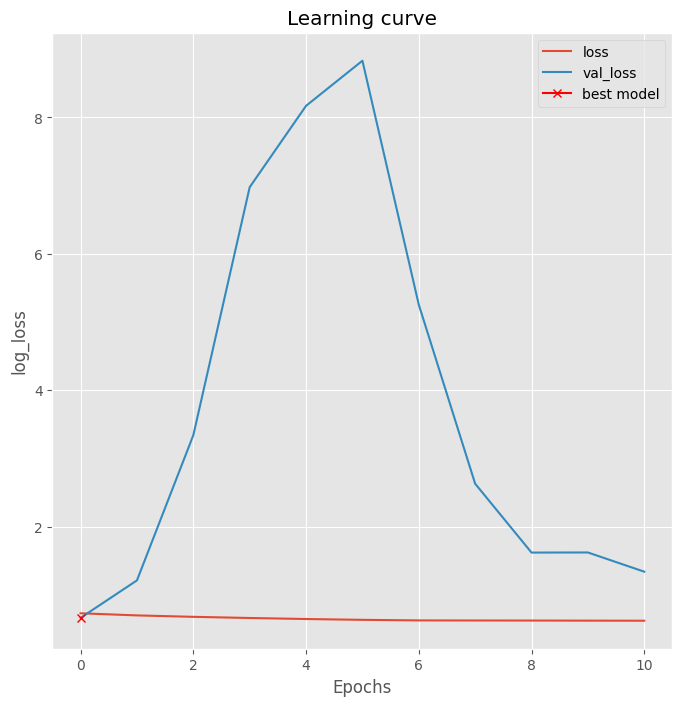

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
def test_unet_with_random_image():
    idx = int(np.random.rand(1)*len(color_test_set))
    y_legit = skimage.img_as_float(normal_test_set[idx]).reshape(1,img_size,img_size,3)
    y_fake = model.predict(skimage.img_as_float(color_test_set[idx]).reshape(1,img_size,img_size,3))
    skimage.io.imshow(skimage.img_as_ubyte(y_legit).reshape(img_size,img_size,3))
    plt.show()
    skimage.io.imshow(skimage.img_as_ubyte(y_fake).reshape(img_size,img_size,3))
    plt.show()

1/1 [==============================] - 0s 23ms/step


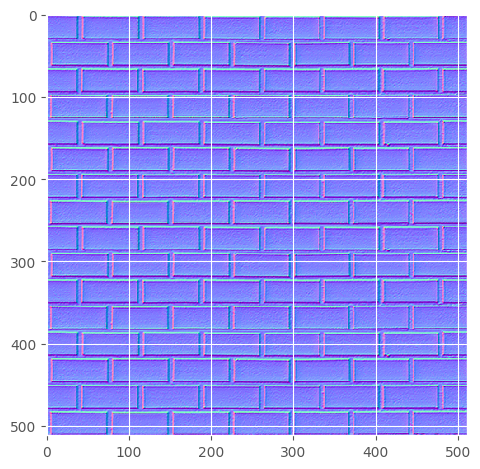

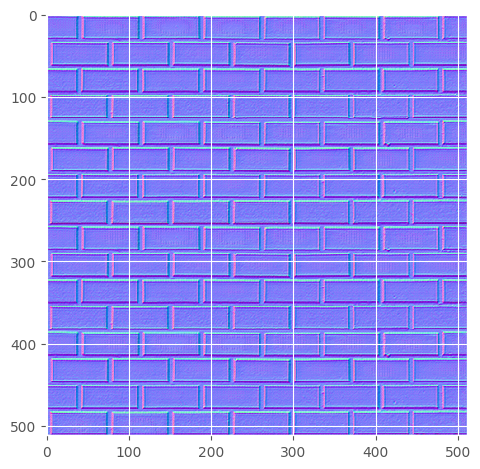

In [ ]:
test_unet_with_random_image()

In [ ]:
model.save('model.h5')